In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Defining spacial and time domain and increments in these domains

In [2]:
# NOTE: All dimensions are in metres and times in seconds

# Time duration of simulation
simulation_duration = 3600  # one hour (in seconds)

# Dimensions of oven
radius_oven = 0.2
height_oven = 0.1

# Increments
dt = 0.25 # Time increment
dr = 0.005 # Radial increment
dz = 0.005 # Height increment


# Defining physical constants

In [3]:
# NOTE: All dimensions are in metres and times in seconds

# Dimensions of pizza
radius_crust = 0.15
radius_tomato_paste = 0.13

height_dough = 0.01
height_tomato_paste = 0.004

# Initial temperatures
temperature_oven_initial = 25
temperature_dough_initial = 30
temperature_tomato_paste_initial = 10

# Constants for dirchlet boundary conditions
temperature_oven_base_centre = 200
temperature_oven_base_outer = 100

# Constants for von-neumann boundary conditions
convective_heat_transfer_coefficient = 500
thermal_conductivity_air = 25
temperature_infinity = 25

# Thermal diffusivities
diffusivity_air = 1.9e-5
diffusivity_crust = 1.28e-7
diffusivity_tomato_paste = 1.737e-7

# Creating dependent variable arrays

In [4]:
def get_dependent_variable_arrays(time_increment, radial_increment, height_increment):

    time_array = np.arange(0, simulation_duration + time_increment, time_increment)
    radius_array = np.arange(0, radius_oven + radial_increment, radial_increment)
    height_array = np.arange(0, height_oven + height_increment, height_increment)
    
    return time_array, radius_array, height_array


In [5]:
def get_number_of_increments_in_dependent_variable_arrays(time_array, radius_array, height_array):

    number_of_increments_in_time_array = len(time_array)
    number_of_increments_in_radius_array = len(radius_array)
    number_of_increments_in_height_array = len(height_array)

    return number_of_increments_in_time_array, number_of_increments_in_radius_array, number_of_increments_in_height_array

# Initializing diffusivity and temperature matrices 

In [6]:
def set_initial_Temperature_and_Diffusivity_matrices(number_time_increments, number_radius_increments, number_height_increments):

    Diffusivity_matrix_initial = np.ndarray(shape=(number_radius_increments, number_height_increments))
    Diffusivity_matrix_initial[:, :] = diffusivity_air

    Temperature_matrix_initial = np.ndarray(shape=(number_time_increments, number_radius_increments, number_height_increments))

    return Temperature_matrix_initial, Diffusivity_matrix_initial

# Boundary Conditions
### Linear Functions for temperature of oven base and wall (dirchlet boundary condition) 

In [7]:
def temperature_oven_base(radius):
    return temperature_oven_base_centre - (temperature_oven_base_centre - temperature_oven_base_outer) * radius / radius_oven


def temperature_oven_wall(height):
    return temperature_oven_base_outer - (temperature_oven_base_outer - temperature_infinity) * height / height_oven

### Setting initial conditions & dirchlet boundary conditions and changing diffisivity matrix

In [8]:
def set_IC_BCs(Temperature_matrix, Diffusivity_matrix, pizza_is_in_oven_bool, radius_array, height_array, number_radius_increments, number_height_increments):

    Temperature_matrix[0, :, :] = temperature_oven_initial

    for i in range(number_radius_increments):
        for j in range(number_height_increments):
            Temperature_matrix[:, i, 0] = temperature_oven_base(radius_array[i])
            Temperature_matrix[:, -1, j] = temperature_oven_wall(height_array[j])
            if pizza_is_in_oven_bool == True:
                if 0 <= radius_array[i] <= radius_crust and 0 <= height_array[j] <= height_dough:
                    Diffusivity_matrix[i, j] = diffusivity_crust
                    Temperature_matrix[0, i, j] = temperature_dough_initial
                if 0 <= radius_array[i] <= radius_tomato_paste and height_dough < height_array[j] <= height_dough + height_tomato_paste:
                    Diffusivity_matrix[i, j] = diffusivity_tomato_paste
                    Temperature_matrix[0, i, j] = temperature_tomato_paste_initial

    return Temperature_matrix, Diffusivity_matrix

# Performing time marching simulation
# using discretised PDE and robin boundary condition

In [9]:
def perform_simulation(Temperature_matrix, Diffusivity_matrix, radius_array, number_time_increments, number_radius_increments, number_height_increments):
    for p in range(1, number_time_increments): # time index, p
        for i in range(number_radius_increments - 2, 0, -1): # radius index, i
            for j in range(1, number_height_increments - 1): # height index, j
                diffusivity = Diffusivity_matrix[i, j]

                # Defining constants for use below
                Cr1 = diffusivity * dt / (2 * dr)
                Cr2 = diffusivity * dt / dr ** 2
                Cz2 = diffusivity * dt / dz ** 2

                # Setting temperature at current dependent variable indexes using discretised PDE:
                Temperature_matrix[p, i, j] = Temperature_matrix[p-1, i-1, j] * (Cr2 - Cr1 * 1 / radius_array[i]) + \
                    Temperature_matrix[p-1, i+1, j] * (Cr2 + Cr1 * 1 / radius_array[i]) + \
                    Temperature_matrix[p-1, i, j] * (1 - 2 * Cr2 - 2 * Cz2) + \
                    Temperature_matrix[p-1, i, j-1] * Cz2 + \
                    Temperature_matrix[p-1, i, j+1] * Cz2

                # dT/dr = 0 at radius = 0 (i = 0):
                Temperature_matrix[p, 0, j] = Temperature_matrix[p, 1, j]

            # Robin boundary condition at height = height_oven (j = -1)
            Temperature_matrix[p, i, -1] = ((thermal_conductivity_air * Temperature_matrix[p, i, -2]) / dz - convective_heat_transfer_coefficient *
                                            temperature_infinity) / (thermal_conductivity_air / dz + convective_heat_transfer_coefficient)

        # Robin B.C. for i = 0 (as this index is missed in above for loop)
        Temperature_matrix[p, 0, -1] = ((thermal_conductivity_air * Temperature_matrix[p, 0, -2]) / dz - convective_heat_transfer_coefficient *
                                        temperature_infinity) / (thermal_conductivity_air / dz + convective_heat_transfer_coefficient)

    return Temperature_matrix

In [10]:
def plot_minimum_and_average_temperature_against_time(Temperature_matrix, time_array, number_time_increments):
    minimum_temperatures = []
    average_temperatures = []

    for p in range(number_time_increments):
        minimum_temperatures.append(np.min(Temperature_matrix[p, :, :]))
        average_temperatures.append(np.average(Temperature_matrix[p, :, :]))

    fig, axs = plt.subplots(1, figsize=(15, 10))

    axs.plot(time_array, average_temperatures, label='Average Temperature', color='orange')
    axs.plot(time_array, minimum_temperatures, label='Minimum Temperature', color='blue')

    axs.legend()

    axs.set_ylabel('Temperature (oC)')
    axs.set_xlabel('Time (s)')

    plt.show()

# Filled Contour plots

In [11]:
def plot_contours(Temperature_matrix, number_of_plots, radius_array, height_array):
    (Zg, Rg) = np.meshgrid(height_array, radius_array)

    if number_of_plots == 3:
        fig, axs = plt.subplots(1,3, figsize=(20,8))

    if number_of_plots == 9:
        fig, axs = plt.subplots(3,3, figsize=(20,20))
    
    row = 1
    col = 1

    if number_of_plots == 3:
        times_of_interest = [0, 500, 10000]

    
    if number_of_plots == 9:
        times_of_interest = [0, 10, 50, 100, 500, 1000, 5000, 10000, 14000]
    
    for time in times_of_interest:

        if number_of_plots == 3:
            axs_index = col - 1
        if number_of_plots == 9:
            axs_index = (row - 1, col - 1)
        
        axs[axs_index].contourf(Rg, Zg, Temperature_matrix[time, :, :])
        axs[axs_index].set_ylabel('Height (m)')
        axs[axs_index].set_xlabel('Radius (m)')

        x_labels = np.arange(0, 0.2+0.05, 0.05)
        axs[axs_index].set_xticks(x_labels)
        axs[axs_index].set_title(f'{time} seconds')

        

        if col % 3 == 0:
            row += 1
            col = 1
        else:
            col += 1

    plt.show()

In [17]:
def perform_simulation_and_plot_contours(time_increment, radial_increment, height_increment, number_of_plots, pizza_is_in_oven_bool, cake_is_in_oven_bool):
    t_array, r_array, z_array = get_dependent_variable_arrays(time_increment, radial_increment, height_increment)
    Nt, Nr, Nz = get_number_of_increments_in_dependent_variable_arrays(t_array, r_array, z_array)
    Temperature_matrix_initial, Diffusivity_matrix_initial = set_initial_Temperature_and_Diffusivity_matrices(Nt, Nr, Nz)
    
    Temperature_matrix, Diffusivity_matrix = set_IC_BCs(
        Temperature_matrix=Temperature_matrix_initial, 
        Diffusivity_matrix=Diffusivity_matrix_initial, 
        pizza_is_in_oven_bool=pizza_is_in_oven_bool, # Means all values in the diffusivity matrix are set to the diffusivity of air 
        radius_array=r_array,
        height_array=z_array,
        number_radius_increments=Nr,
        number_height_increments=Nz)

    Temperature_matrix = perform_simulation(
        Temperature_matrix=Temperature_matrix, 
        Diffusivity_matrix=Diffusivity_matrix,
        radius_array=r_array,
        number_time_increments=Nt,
        number_radius_increments=Nr,
        number_height_increments=Nz)

    plot_contours(Temperature_matrix = Temperature_matrix, 
        number_of_plots = number_of_plots,
        radius_array = r_array,
        height_array = z_array)

    return Temperature_matrix

# Simulation with pizza in oven

(41, 21)
(41, 21)
(41, 21)


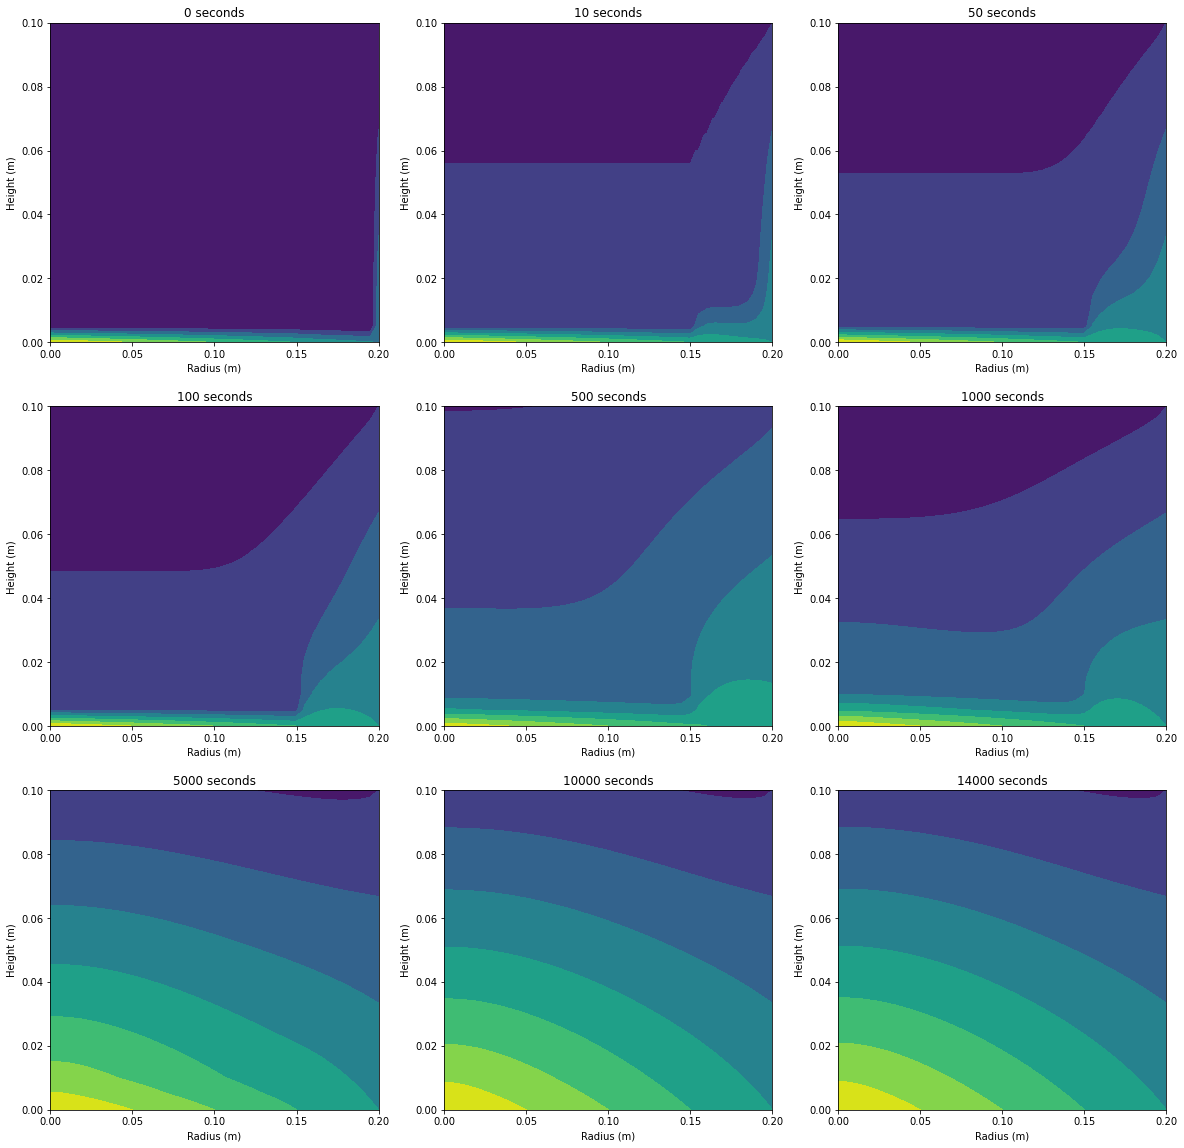

In [23]:
dt = 0.25
dr = 0.005
dz = 0.005

Temperature_with_pizza_matrix = perform_simulation_and_plot_contours(
    time_increment=dt, 
    radial_increment=dr, 
    height_increment=dz, 
    number_of_plots=9, 
    pizza_is_in_oven_bool=True, 
    cake_is_in_oven_bool=False    
)

## Average and Minimum temperatures against time

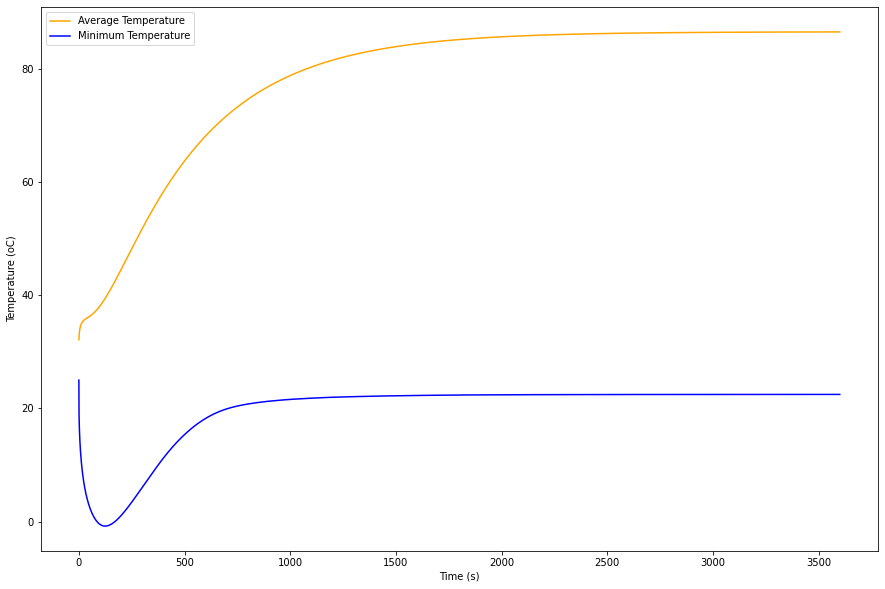

In [24]:
t_array, r_array, z_array = get_dependent_variable_arrays(time_increment=dt, radial_increment=dr, height_increment=dz)
Nt, Nr, Nz = get_number_of_increments_in_dependent_variable_arrays(t_array, r_array, z_array)
plot_minimum_and_average_temperature_against_time(Temperature_matrix=Temperature_with_pizza_matrix, time_array=t_array, number_time_increments=Nt)

# Simulation with no pizza in oven

In [14]:
dt = 0.25
dr = 0.005
dz = 0.005

perform_simulation_and_plot_contours(
    time_increment=dt, 
    radial_increment=dr, 
    height_increment=dz, 
    number_of_plots=3, 
    pizza_is_in_oven_bool=False, 
    cake_is_in_oven_bool=False    
)

t_array, r_array, z_array = get_dependent_variable_arrays(time_increment=dt, radial_increment=dr, height_increment=dz)
plot_contours(Temperature_matrix=Temperature_with_pizza_matrix, number_of_plots=3, radius_array=r_array, height_array=z_array)


# Grid Analysis

(21, 11)
(21, 11)
(21, 11)


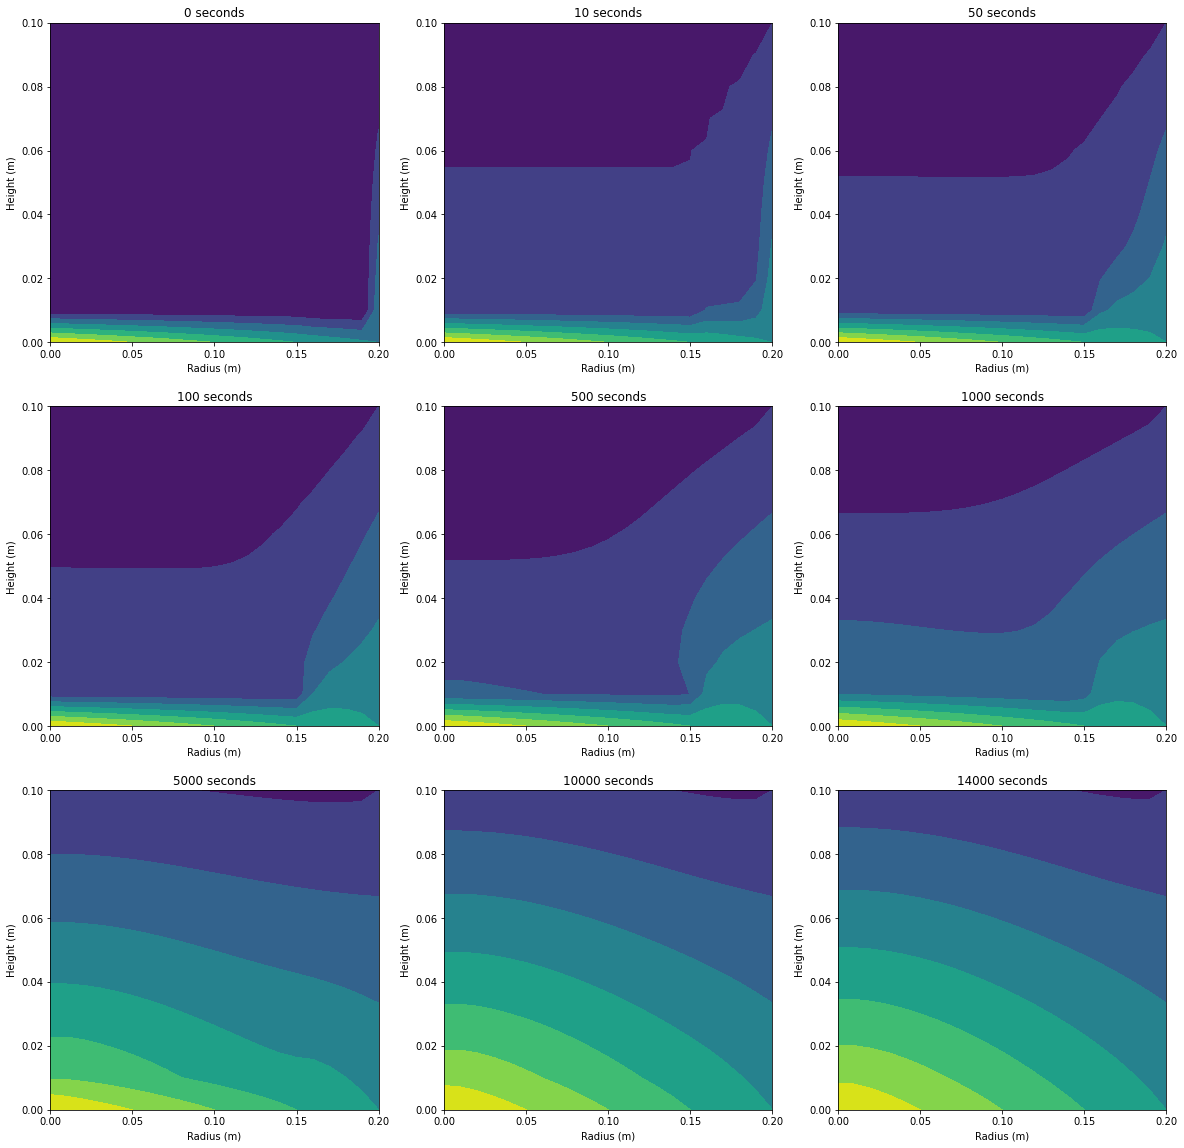

In [19]:
# 2 times coarser grids (spatial increments are 2 times larger)

dt = 0.25
dr = 0.01
dz = 0.01

Temperature_with_pizza_matrix_2_times_coarser_grid = perform_simulation_and_plot_contours(
    time_increment=dt, 
    radial_increment=dr, 
    height_increment=dz, 
    number_of_plots=9, 
    pizza_is_in_oven_bool=True, 
    cake_is_in_oven_bool=False    
)

(5, 4)
(5, 4)
(5, 4)


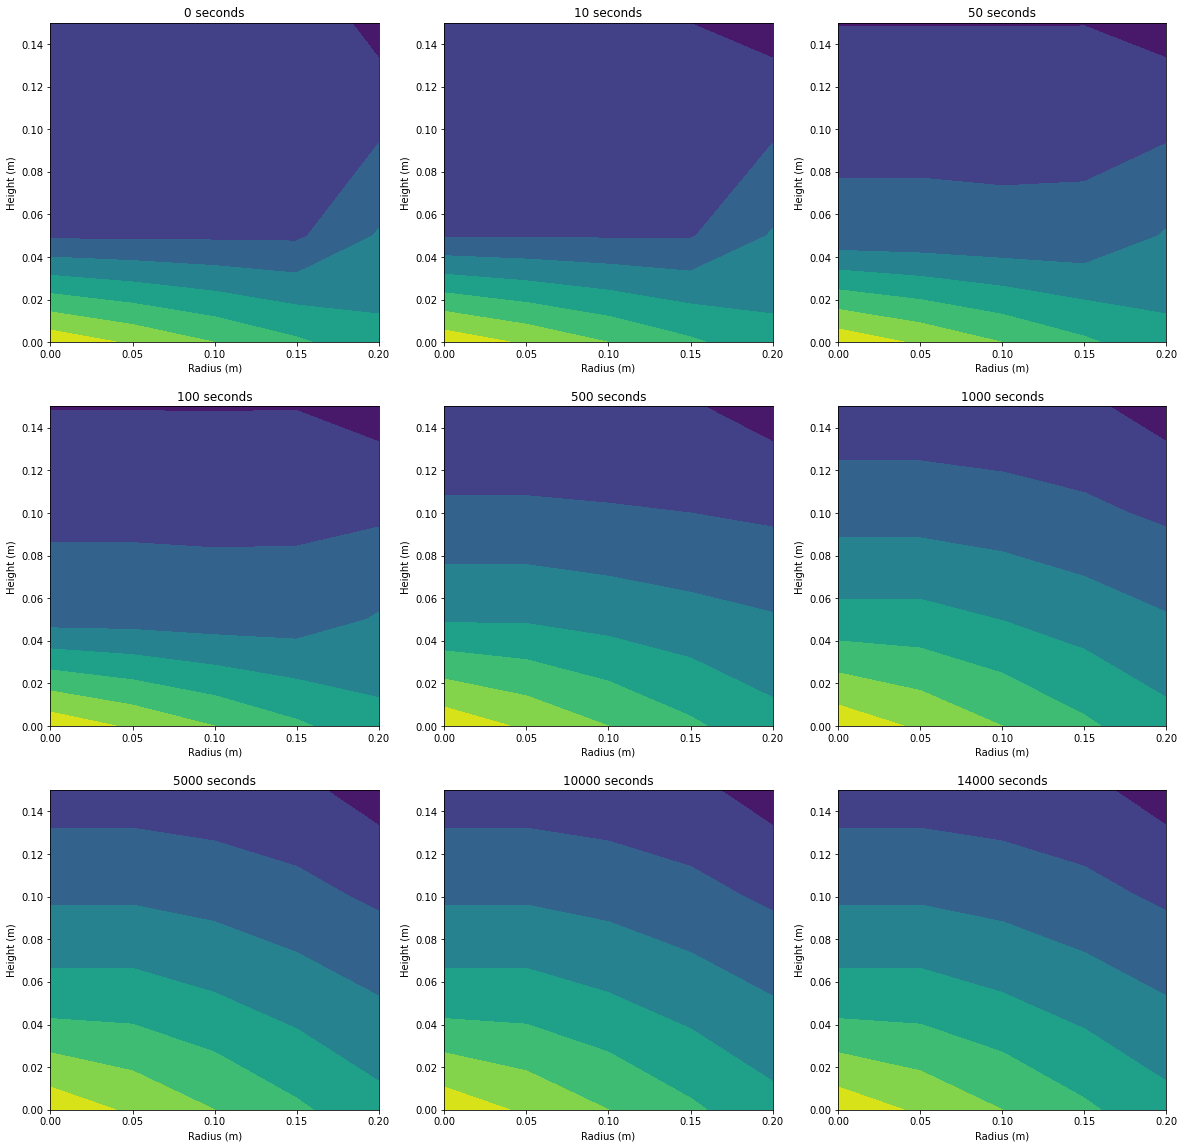

In [ ]:
# 10 times coarser grids (spatial increments are 10 times larger)

dt = 0.25
dr = 0.05
dz = 0.05

Temperature_with_pizza_matrix_2_times_coarser_grid = perform_simulation_and_plot_contours(
    time_increment=dt, 
    radial_increment=dr, 
    height_increment=dz, 
    number_of_plots=9, 
    pizza_is_in_oven_bool=True, 
    cake_is_in_oven_bool=False    
)